In [1]:
# Import the dependencies

import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt


2024-06-06 21:31:02.763720: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define directory containing the csv files
dir_path = Path("../Resources")

# create an empty list to hold the dataframes 
dfs = []

# loop through each file in the directory
for file in os.listdir(dir_path):
    # check if the file is a csv file
    if file.endswith(".csv"):
        # extract the ticker symbol from the file name (assuming the file name is the ticker symbol)
        ticker = file.replace(".csv", "")
        # Read the file into a DataFrame
        stocks_df = pd.read_csv(dir_path / file)
        # Add a column to the DataFrame to store the ticker symbol
        stocks_df["Ticker"] = ticker
        # add the dataframe to the list
        dfs.append(stocks_df)
        
# concatenate the dataframes in the list
combined_stocks_df = pd.concat(dfs, ignore_index=True)

# Display the combined DataFrame to verify
print(combined_stocks_df.head())

         Date  Open      High       Low     Close  Adj Close     Volume Ticker
0  1990-02-16   0.0  0.079861  0.073785  0.077257   0.052392  940636800   CSCO
1  1990-02-20   0.0  0.079861  0.074653  0.079861   0.054158  151862400   CSCO
2  1990-02-21   0.0  0.078993  0.075521  0.078125   0.052980   70531200   CSCO
3  1990-02-22   0.0  0.081597  0.078993  0.078993   0.053569   45216000   CSCO
4  1990-02-23   0.0  0.079861  0.078125  0.078559   0.053275   44697600   CSCO


/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_5729/227121164.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_stocks_df = pd.concat(dfs, ignore_index=True)


In [3]:
# view the shape of the data
print(combined_stocks_df.shape)

(524382, 8)


In [4]:
# change the type in 'date' column to datetime
combined_stocks_df["Date"] = pd.to_datetime(combined_stocks_df["Date"])

# Filter the data for the last 5 years from today
twenty_five_years_ago = pd.Timestamp.today() - pd.DateOffset(years=25)
stocks_data_filtered = combined_stocks_df[combined_stocks_df["Date"] >= twenty_five_years_ago]

print(stocks_data_filtered.head())
print(stocks_data_filtered.tail())



           Date       Open       High        Low      Close  Adj Close  \
2349 1999-06-07  28.671875  29.062500  28.437500  28.843750  19.560369   
2350 1999-06-08  28.765625  29.125000  27.781250  27.921875  18.935198   
2351 1999-06-09  28.125000  28.500000  27.750000  28.437500  19.284868   
2352 1999-06-10  28.312500  28.312500  27.421875  27.609375  18.723278   
2353 1999-06-11  27.703125  28.109375  27.625000  27.671875  18.765663   

        Volume Ticker  
2349  43156000   CSCO  
2350  42976400   CSCO  
2351  36088400   CSCO  
2352  46404800   CSCO  
2353  42778800   CSCO  
             Date        Open        High         Low       Close   Adj Close  \
524377 2024-04-17  950.000000  952.489990  910.260010  912.260010  912.260010   
524378 2024-04-18  909.229980  909.330017  884.390015  888.919983  888.919983   
524379 2024-04-19  894.940002  899.679993  861.950012  870.250000  870.250000   
524380 2024-04-22  876.400024  878.739990  857.979980  868.070007  868.070007   
524381

In [5]:
# Initialize a dictionary to hold the MSE for each stock symbol
mse_dict = {}

# Initialize a dictionary to hold the predictions for each stock symbol
predictions_dict = {}

# Group the data by ticker symbol
stocks_grouped = stocks_data_filtered.groupby("Ticker")

# # Iterate through each group (stock symbol)
for ticker, group in stocks_grouped:
    # Create a copy of the group's data
    group_copy = group.copy()
    
    # Set the date as the index
    group_copy.set_index("Date", inplace=True)
    
    # Define a feature int he data for previous date closing prices
    group_copy["Previous Day Close"] = group_copy["Close"].shift(1)
    
    # Define a feature in the data for the volume
    group_copy["Volume Difference"] = group_copy["Volume"].diff()
    
    # Drop rows with NaN values
    group_copy = group_copy.dropna()
    
    # Define the features (X) and the target (y) variables for training purposes
    X = group_copy[["Previous Day Close", "Volume Difference"]]
    y = group_copy["Close"].values.reshape(-1, 1) 
    
    # split the data into training and testing sets chronologically
    split = int(0.7 * len(X))
    X_train = X[: split]
    X_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions using the testing data
    predictions = model.predict(X_test)
    
    # Calculate the mean_squared_error on the testing data
    mse = mean_squared_error(y_test, predictions)
    
    # Store the MSE in the dictionary
    mse_dict[ticker] = mse
    
        # Make a prediction for the values of the stock over the next year starting from the last date for each stock in the dataset
    # Create a dataframe to hold the predictions
    future_dates = pd.date_range(start=group_copy.index[-1], periods=180, freq='M')
    future_dates_df = pd.DataFrame(future_dates, columns=["Date"])
    future_dates_df.set_index("Date", inplace=True)
    
    # Initialize previous_close with the last available close value
    previous_close = group_copy["Close"].iloc[-1]
    volume_difference = 0

    # Predict the future values iteratively
    future_closes = []
    for date in future_dates_df.index:
        # prepare the input data for prediction
        input_data = pd.DataFrame({"Previous Day Close": [previous_close], "Volume Difference": [volume_difference]})
        # Make the prediction
        predicted_close = model.predict(input_data)[0][0]
        # Append the predicted close to the list
        future_closes.append(predicted_close)
        # Update previous_close for the next iteration
        previous_close = predicted_close
    
    # Add the predictions to the dataframe
    future_dates_df["Close"] = future_closes
    
    # Store the predictions in the dictionary
    predictions_dict[ticker] = future_dates_df

/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_5729/536286253.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=group_copy.index[-1], periods=180, freq='M')
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_5729/536286253.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=group_copy.index[-1], periods=180, freq='M')
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_5729/536286253.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=group_copy.index[-1], periods=180, freq='M')
/var/folders/f4/7lkrmhr91498yvvn03jsc52c0000gp/T/ipykernel_5729/536286253.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(sta

In [6]:
# Display the MSE for each stock ticker
for ticker, mse in mse_dict.items():
    print(f"Stock Ticker: {ticker}, Mean Squared Error: {mse}")

Stock Ticker: AAPL, Mean Squared Error: 4.204097255943988
Stock Ticker: ADBE, Mean Squared Error: 75.2876513683009
Stock Ticker: ADI, Mean Squared Error: 7.081829219737432
Stock Ticker: ADP, Mean Squared Error: 7.626064634255854
Stock Ticker: ALGN, Mean Squared Error: 108.65387136254888
Stock Ticker: AMD, Mean Squared Error: 6.53710575835278
Stock Ticker: AMGN, Mean Squared Error: 10.979585676438994
Stock Ticker: AMZN, Mean Squared Error: 6.175138621060245
Stock Ticker: ANSS, Mean Squared Error: 29.884810077554896
Stock Ticker: ASML, Mean Squared Error: 135.84153284873682
Stock Ticker: AVGO, Mean Squared Error: 201.5657143601602
Stock Ticker: BIIB, Mean Squared Error: 58.74492640655592
Stock Ticker: BKNG, Mean Squared Error: 1857.5289894355544
Stock Ticker: CDNS, Mean Squared Error: 7.783698719873542
Stock Ticker: CDW, Mean Squared Error: 8.985980707537006
Stock Ticker: CHKP, Mean Squared Error: 3.0994430098960133
Stock Ticker: CHTR, Mean Squared Error: 103.02022536776691
Stock Ticker:

In [7]:
# Display the predictions for each stock ticker
for ticker, future_dates_df in predictions_dict.items():
    print(f"Predictions for {ticker}:")
    print(future_dates_df)


Predictions for AAPL:
                 Close
Date                  
2024-04-30  166.920592
2024-05-31  166.941192
2024-06-30  166.961794
2024-07-31  166.982398
2024-08-31  167.003004
...                ...
2038-11-30  170.554228
2038-12-31  170.575158
2039-01-31  170.596090
2039-02-28  170.617024
2039-03-31  170.637959

[180 rows x 1 columns]
Predictions for ADBE:
                 Close
Date                  
2024-04-30  472.959894
2024-05-31  473.019799
2024-06-30  473.079709
2024-07-31  473.139625
2024-08-31  473.199545
...                ...
2038-11-30  483.522763
2038-12-31  483.583584
2039-01-31  483.644411
2039-02-28  483.705242
2039-03-31  483.766079

[180 rows x 1 columns]
Predictions for ADI:
                 Close
Date                  
2024-04-30  189.194641
2024-05-31  188.462968
2024-06-30  187.734957
2024-07-31  187.010588
2024-08-31  186.289843
...                ...
2038-11-30  103.749713
2038-12-31  103.445560
2039-01-31  103.142928
2039-02-28  102.841811
2039-03-31  1

In [8]:
# Define the base path as the parent directory of "Notebooks" and "Resources"
base_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Create a directory named "Predictions" within the base path if it doesn't exist
predictions_folder = os.path.join(base_path, "Fifteen Year Predictions")
if not os.path.exists(predictions_folder):
    os.makedirs(predictions_folder)

# Save the Predictions results to individual files in the "Predictions" folder
for ticker, future_dates_df in predictions_dict.items():
    prediction_file_path = os.path.join(predictions_folder, f"predictions_{ticker}.csv")
    future_dates_df.to_csv(prediction_file_path)

print(f"Prediction results saved to the folder: {predictions_folder}")

# Create a directory named "MSE" within the base path if it doesn't exist
mse_folder = os.path.join(base_path, "MSE Output Fifteen Year")
if not os.path.exists(mse_folder):
    os.makedirs(mse_folder)

# Define the path to save the MSE results file
mse_file_path = os.path.join(mse_folder, "mse_results.csv")

# Save the MSE results to a file in the "MSE" folder
mse_df = pd.DataFrame(list(mse_dict.items()), columns=["Stock Ticker", "Mean Squared Error"])
mse_df.to_csv(mse_file_path, index=False)

print(f"MSE results saved to: {mse_file_path}")


Prediction results saved to the folder: /Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/stockmarket-machinelearningproject/Fifteen Year Predictions
MSE results saved to: /Users/paulettepetracco/Bootcamp_Code_Challenges/GH_Repositories/Project_4/stockmarket-machinelearningproject/MSE Output Fifteen Year/mse_results.csv


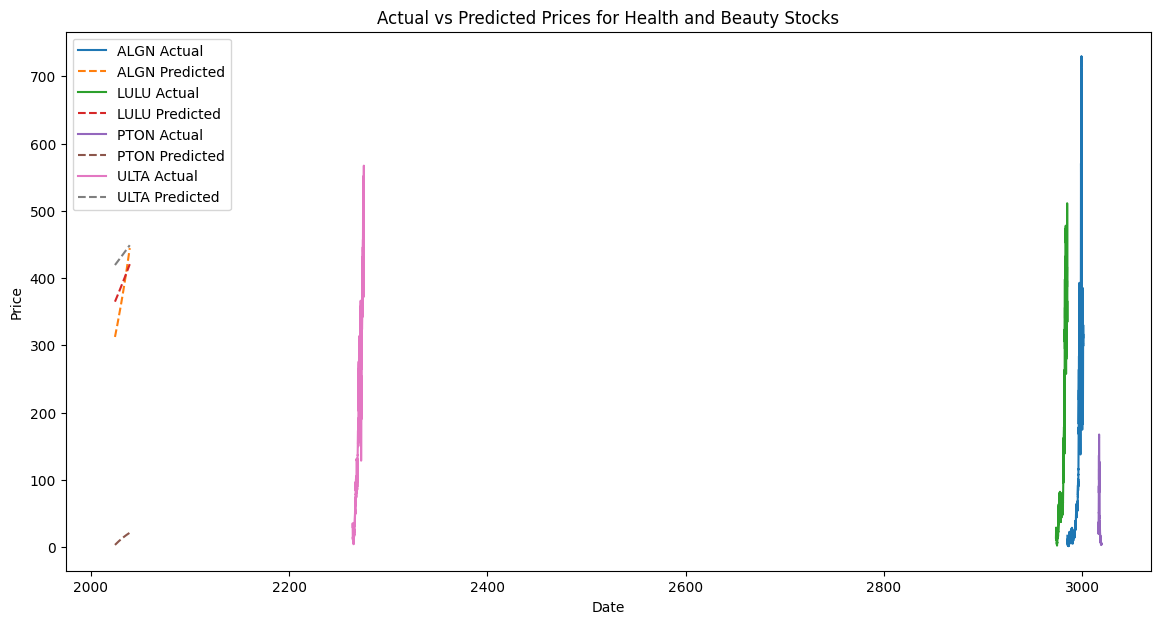

In [9]:
# Function to plot actual vs predicted prices for multiple stocks
def plot_multiple_stocks_actual_vs_predicted(tickers, combined_stocks_df, predictions_dict):
    plt.figure(figsize=(14, 7))
    
    for ticker in tickers:
        # Filter actual prices for the ticker
        actual_prices = combined_stocks_df[combined_stocks_df['Ticker'] == ticker]
        # Get predicted prices for the ticker
        predicted_prices = predictions_dict[ticker]
        
        # Plot actual prices
        plt.plot(actual_prices.index, actual_prices['Close'], label=f"{ticker} Actual")
        # Plot predicted prices
        plt.plot(predicted_prices.index, predicted_prices['Close'], linestyle='dashed', label=f"{ticker} Predicted")
    
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Actual vs Predicted Prices for Health and Beauty Stocks")
    plt.legend()
    plt.show()

# List of tickers to compare
tickers = ['ALGN', 'LULU', 'PTON', 'ULTA']

# Ensure combined_stocks_df has a 'Ticker' column
# Assuming 'combined_stocks_df' already has the 'Ticker' column after loading data
# combined_stocks_df['Ticker'] = ...

# Plot the actual vs predicted prices for the specified tickers
plot_multiple_stocks_actual_vs_predicted(tickers, combined_stocks_df, predictions_dict)


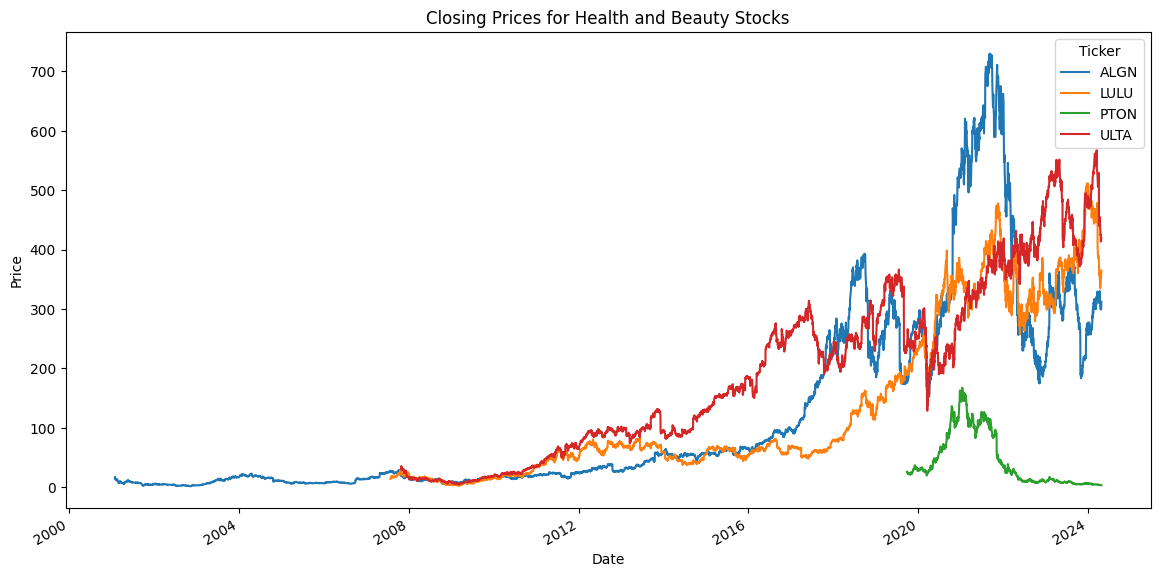

In [10]:
# create a line graph with multiple stocks: BIIB, GILD, INCY, VRTX
# Filter the data for the last 15 years from today
twenty_five_years_ago = pd.Timestamp.today() - pd.DateOffset(years=25)
stocks_data_filtered = combined_stocks_df[combined_stocks_df["Date"] >= twenty_five_years_ago] 

# Define the list of tickers to plot
tickers = ['ALGN', 'LULU', 'PTON', 'ULTA']

# Filter the data for the specified tickers
filtered_data = stocks_data_filtered[stocks_data_filtered["Ticker"].isin(tickers)]

# Pivot the data to have the tickers as columns
pivoted_data = filtered_data.pivot(index="Date", columns="Ticker", values="Close")

# Plot the data
pivoted_data.plot(figsize=(14, 7))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Closing Prices for Health and Beauty Stocks")
plt.show()

# Function to plot the actual and predicted prices for a stock
def plot_actual_vs_predicted(ticker, historical_df, predictions_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df.index, historical_df['Close'], label="Actual Prices")
    plt.plot(predictions_df.index, predictions_df['Close'], label="Predicted Prices", linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs Predicted Prices for {ticker}")
    plt.legend()
    plt.show()

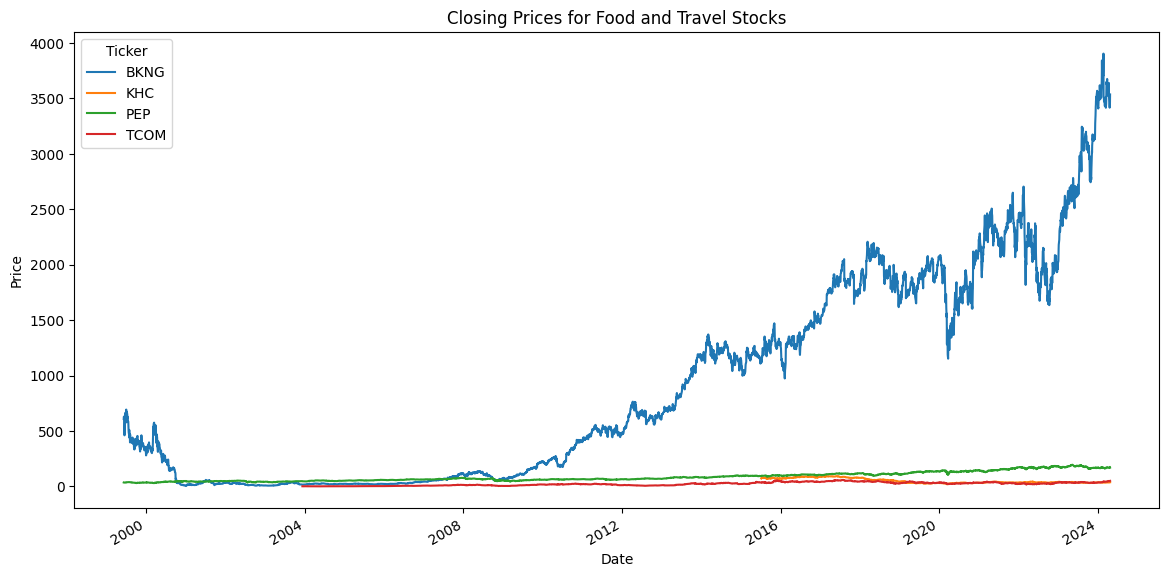

In [11]:
# create a line graph with multiple stocks: BIIB, GILD, INCY, VRTX
# Filter the data for the last 15 years from today
twenty_five_years_ago = pd.Timestamp.today() - pd.DateOffset(years=25)
stocks_data_filtered = combined_stocks_df[combined_stocks_df["Date"] >= twenty_five_years_ago] 

# Define the list of tickers to plot
tickers = ['BKNG', 'KHC', 'PEP', 'TCOM']

# Filter the data for the specified tickers
filtered_data = stocks_data_filtered[stocks_data_filtered["Ticker"].isin(tickers)]

# Pivot the data to have the tickers as columns
pivoted_data = filtered_data.pivot(index="Date", columns="Ticker", values="Close")

# Plot the data
pivoted_data.plot(figsize=(14, 7))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Closing Prices for Food and Travel Stocks")
plt.show()

# Function to plot the actual and predicted prices for a stock
def plot_actual_vs_predicted(ticker, historical_df, predictions_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df.index, historical_df['Close'], label="Actual Prices")
    plt.plot(predictions_df.index, predictions_df['Close'], label="Predicted Prices", linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs Predicted Prices for {ticker}")
    plt.legend()
    plt.show()

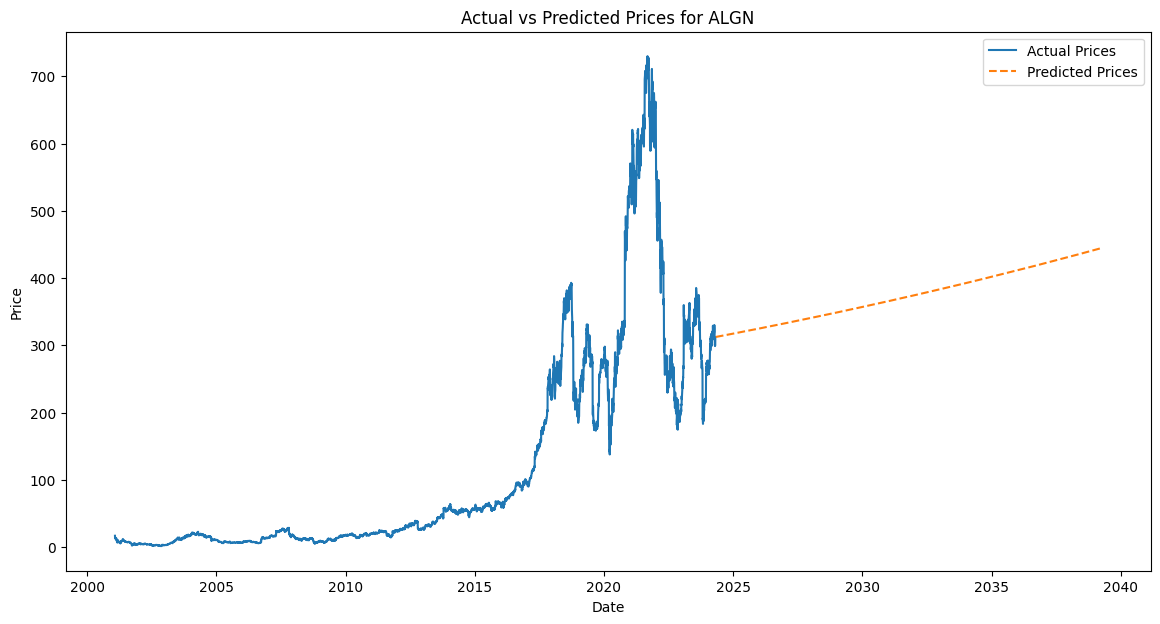

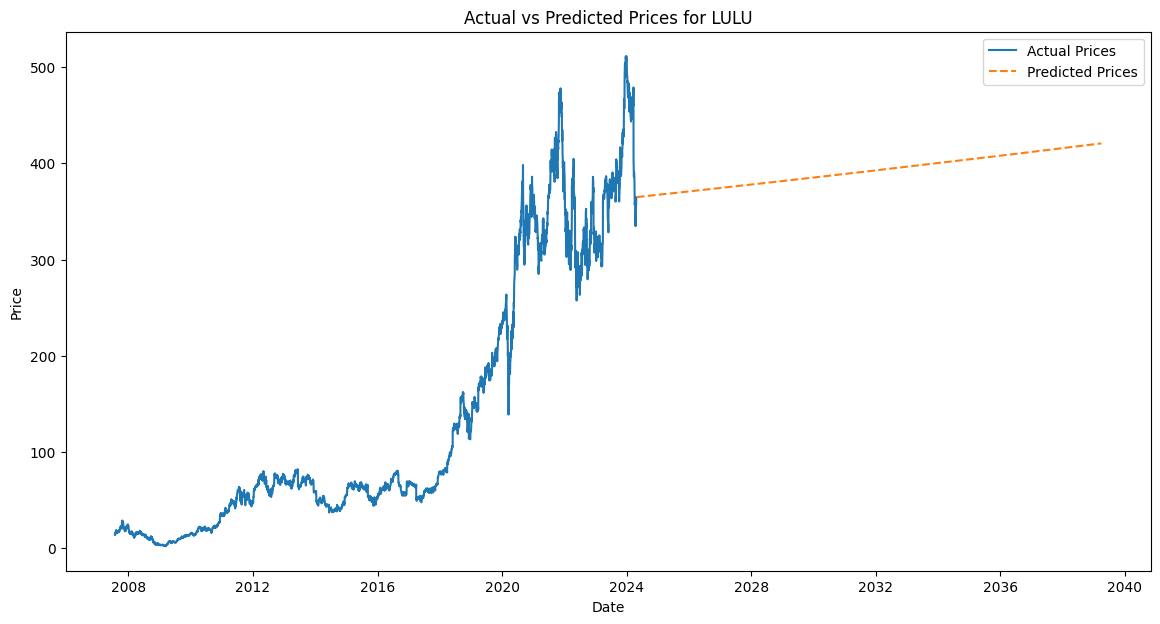

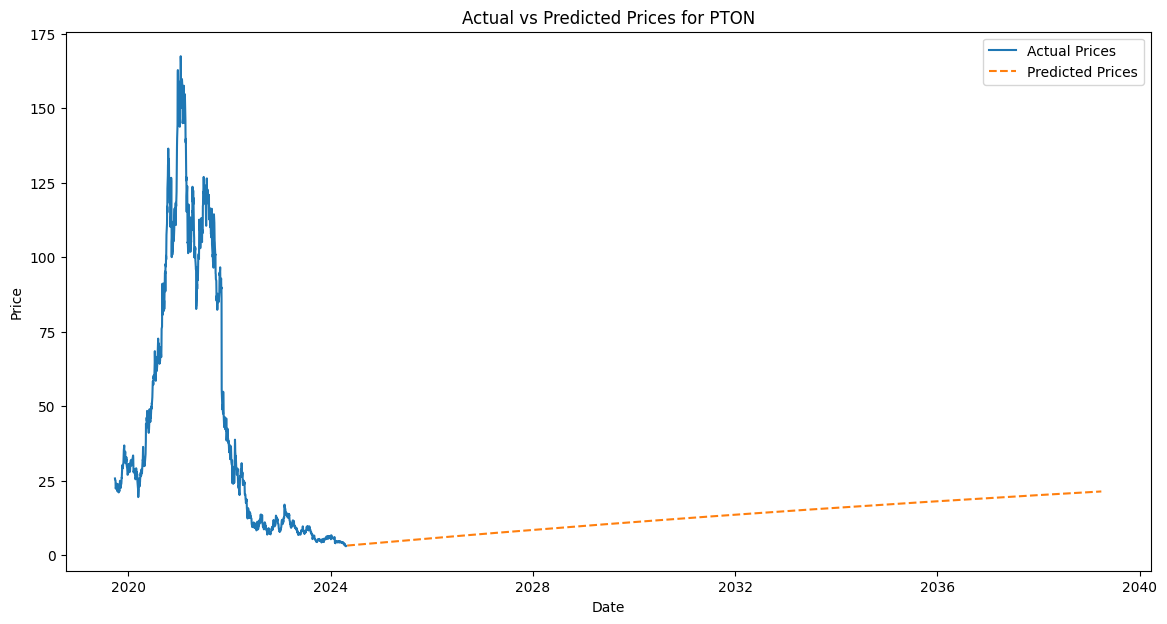

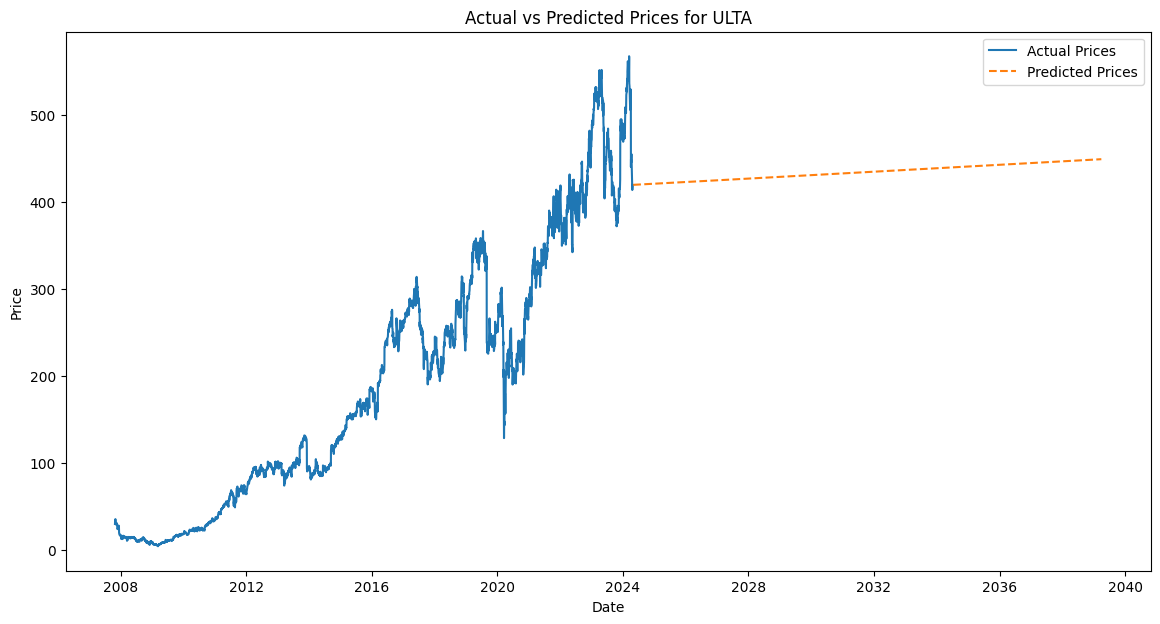

In [12]:
# create a line graph with bio stocks: BIIB, GILD, INCY, VRTX for predicted prices for the next 15 years
# Define the list of tickers to plot
tickers = ['ALGN', 'LULU', 'PTON', 'ULTA']

# Plot the actual vs predicted prices for the specified tickers
for ticker in tickers:
    # Get the historical data for the stock
    historical_data = combined_stocks_df[combined_stocks_df["Ticker"] == ticker]
    historical_data.set_index("Date", inplace=True)
    
    # Get the predicted prices for the stock
    predicted_data = predictions_dict[ticker]
    
    # Plot the actual vs predicted prices
    plot_actual_vs_predicted(ticker, historical_data, predicted_data)
    
# Function to plot the actual and predicted prices for a stock
def plot_actual_vs_predicted(ticker, historical_df, predictions_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df.index, historical_df['Close'], label="Actual Prices")
    plt.plot(predictions_df.index, predictions_df['Close'], label="Predicted Prices", linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs Predicted Prices for {ticker}")
    plt.legend()
    plt.show()

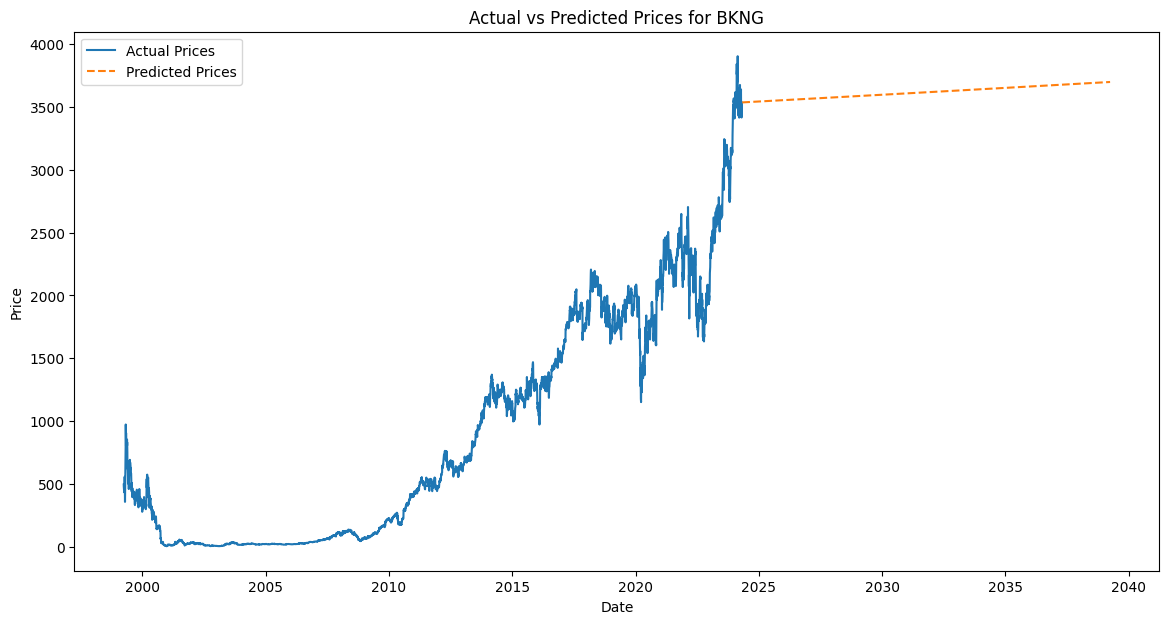

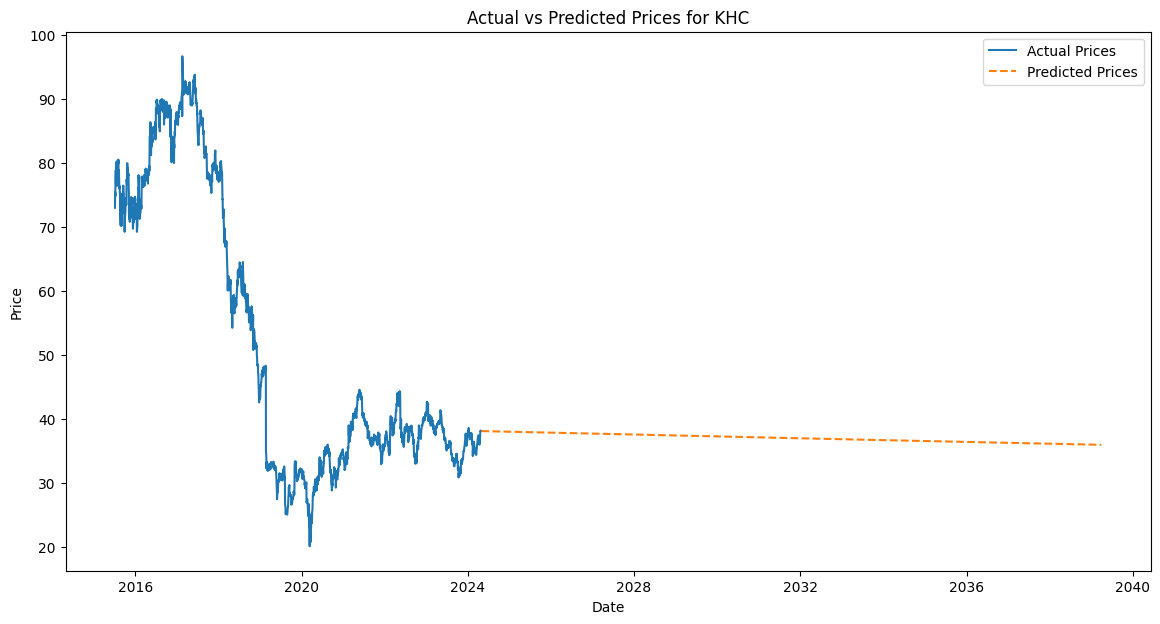

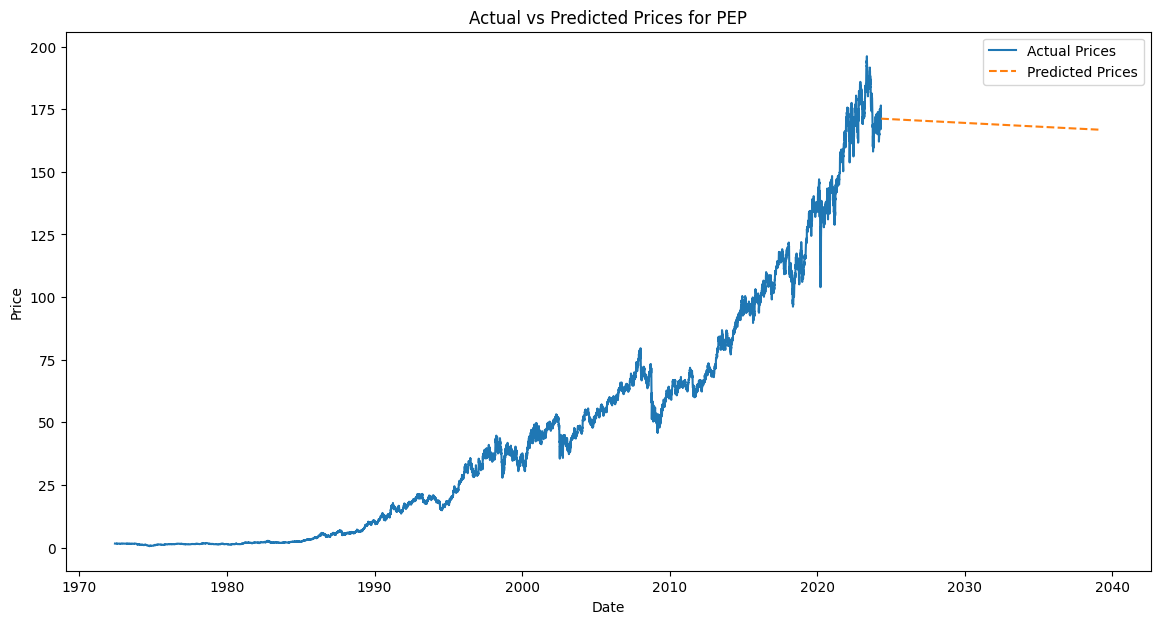

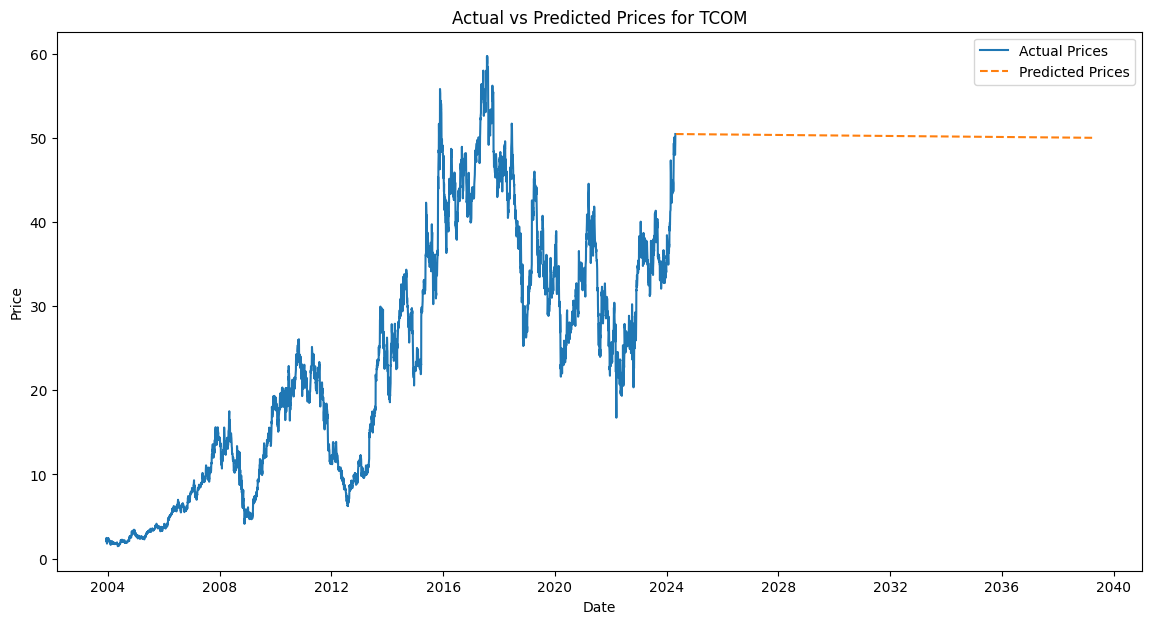

In [13]:
# create a line graph with bio stocks: BIIB, GILD, INCY, VRTX for predicted prices for the next 15 years
# Define the list of tickers to plot
tickers = ['BKNG', 'KHC', 'PEP', 'TCOM']

# Plot the actual vs predicted prices for the specified tickers
for ticker in tickers:
    # Get the historical data for the stock
    historical_data = combined_stocks_df[combined_stocks_df["Ticker"] == ticker]
    historical_data.set_index("Date", inplace=True)
    
    # Get the predicted prices for the stock
    predicted_data = predictions_dict[ticker]
    
    # Plot the actual vs predicted prices
    plot_actual_vs_predicted(ticker, historical_data, predicted_data)
    
# Function to plot the actual and predicted prices for a stock
def plot_actual_vs_predicted(ticker, historical_df, predictions_df):
    plt.figure(figsize=(14, 7))
    plt.plot(historical_df.index, historical_df['Close'], label="Actual Prices")
    plt.plot(predictions_df.index, predictions_df['Close'], label="Predicted Prices", linestyle='dashed')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs Predicted Prices for {ticker}")
    plt.legend()
    plt.show()